In [196]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Data preprocessing for HCMC survey dataset"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"


# Feature selection done by testing lasso regression 

Compare outputs of feature selections done by lasso regresion, CIT, xgboos

Ridge regression has benefits when dealing with large ds and overfitting might be a problem during model training. 
Ridge regression - in contrast to other models - doesnt directly nullify the inlfuence of less important features - good to determine variables with zero effects

"""
  https://medium.com/@sabarirajan.kumarappan/feature-selection-by-lasso-and-ridge-regression-python-code-examples-1e8ab451b94b
key difference however, between Ridge and Lasso regression is that Lasso Regression has the ability to nullify the impact of an irrelevant feature in the data, meaning that it can reduce the coefficient of a feature to zero thus completely eliminating it and hence is better at reducing the variance when the data consists of many insignificant features. Ridge regression, however, can not reduce the coefficients to absolute zero.
Ridge regression performs better when the data consists of features which are sure to be more relevant and useful.

"""

Code idea maily from: https://medium.com/@sabarirajan.kumarappan/feature-selection-by-lasso-and-ridge-regression-python-code-examples-1e8ab451b94b

In [197]:
import numpy as np
import pandas as pd

import pickle

from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_selection import SelectFromModel



from sklearn.metrics import accuracy_score# , confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split, RepeatedStratifiedKFold, cross_val_score

import matplotlib.pyplot as plt


seed = np.random.seed(11)

import warnings
warnings.filterwarnings('ignore')



In [198]:
df_candidates = pd.read_excel("../../input_survey_data/input_data_business_2.xlsx")
print(df_candidates.shape)
df_candidates.tail(2)


(397, 60)


,Target_contentloss_euro,Target_businessreduction,inundation_duration_h,water_depth_cm,contaminations.0,contaminations.1,contaminations.2,contaminations.3,contaminations.4,flowvelocity,...,resilience_govern_careing,resilience_govern_careing_increases,resilience_left_alone,resilience_neighbor_management,perception_who_responsible4protection.Rank1,perception_govern_support_future,perception_private_economy_future,shp_content_value_euro,shp_registered_capital_euro,elevation_m
395,0.0,NaN,4.0,70.0,0,1,0,0,1,1,...,1.0,1.0,5,1.0,2.0,1.0,3.0,NaN,11047.7,1.83886
396,0.0,0.0,3.0,100.0,0,1,0,0,1,1,...,NaN,NaN,5,NaN,3.0,NaN,3.0,NaN,736.5,1.87277


#### Split Data and Normalize variables 
- due that most variables dont have a gaussian distribution, donwside is that distance to outliers is decreased so outliers have influence on the loss calculation (smaller standard deviations when using normaization)


In [199]:
# ## clean df from few nan values

# print(df_candidates.isna().sum())
# df_candidates = df_candidates.dropna()
# print(df_candidates.shape)


# # ## clean df from few nan values
print(df_candidates.isna().sum())
df_candidates = df_candidates.replace(np.nan, 0)


## TODO fix missing values by filling or rmeoving them:
## Idea: remove nan in targets (->get 2 ds) and fill missing values in candidate predictors
## or think about to remove predictors with very many missing values , even they are significant correlated to target eg. warning time



Target_contentloss_euro                         11
Target_businessreduction                        36
inundation_duration_h                            9
water_depth_cm                                   1
contaminations.0                                 0
contaminations.1                                 0
contaminations.2                                 0
contaminations.3                                 0
contaminations.4                                 0
flowvelocity                                     0
warning_time_h                                 308
emergency_measures.1                             0
emergency_measures.2                             0
emergency_measures.3                             0
emergency_measures.4                             0
emergency_measures.6                             0
emergency_measures.7                             0
emergency_measures.8                             0
emergency_measures.9                             0
overall_problem_house          

In [200]:
df_candidates["Target_contentloss_euro"].shape

(397,)

In [201]:
targets = ["Target_contentloss_euro", "Target_businessreduction"]

X_unscaled = df_candidates.drop(targets, axis=1)


In [202]:
# param_dist = {'n_estimators': [10, 100, 200, 500],
#               'max_depth': [1, 3, 5, 10,20],
#               'colsample_bynode': [0.1, 0.3] # nbr of feautres for each split point
#               #'subsample': 0.8  # define subsample of train st, xgb has not bootstrapping
#               }

y_train.shape

(265,)

In [236]:
## iterate over both targets and store results 

for target in ["Target_contentloss_euro", "Target_businessreduction"]:

    y = df_candidates[target]
    
    ## normalize data 
    scaler = MinMaxScaler() 
    X = scaler.fit_transform(pd.DataFrame(X_unscaled))
    y = scaler.fit_transform(pd.DataFrame(y))
    
    ## test train split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed, shuffle=True)

    # classes have to start from zero on for lasso regression, make continous variables as categorical 
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)

    ## set up model
    lasso_ = SelectFromModel(LogisticRegression(C=1, penalty="l1", solver="liblinear", random_state=seed)) # L1 =lasso Regression
    lasso_.fit(X_train, y_train) #np.ravel(y_train,order="C"))

    X_train = pd.DataFrame(X_train)

    ## store trained model for evaluation
    filename = f'./models_trained/lasso_{target}.sav'
    pickle.dump(lasso_, open(filename, 'wb'))


    ## Select features
    print("Lasso regression:")
    selected_feat = X_train.columns[(lasso_.get_support())]
    not_selected_feat = X_train.columns[~(lasso_.get_support())]

    print("total features: {}".format((X_train.shape[1])))
    print("selected features: {}".format(len(selected_feat)))
    print("dropped features: \n{}\n".format(X_unscaled.columns[not_selected_feat].to_list()))
    #print("features with coefficients shrank to zero: {}".format(np.sum(lasso_.estimator_.coef_ == 0)))
    print(f"Selected features: \n{X_unscaled.columns[selected_feat]}")
    #X_train[(ridge_.estimator_.coef_ == 0)#]


    ## write selected features to disk
    df_lasso = df_candidates[[target] + X_unscaled.columns[lasso_.get_support()].to_list()]
    #df_lasso.info()
    df_lasso.to_excel(f"../../input_survey_data/fs_lasso_{target}.xlsx", index=False)


    # ## predict unseen X_test set
    # y_lasso_pred = lasso_.predict(X_test)


Lasso regression:
total features: 58
selected features: 44
dropped features: 
['inundation_duration_h', 'contaminations.3', 'warning_time_h', 'bage', 'b_area', 'hh_monthly_income_cat', 'shp_owner', 'shp_sector', 'shp_employees', 'shp_avgmonthly_sale_cat', 'shp_monetary_resources4prevention', 'perception_who_responsible4protection.Rank1', 'shp_content_value_euro', 'shp_registered_capital_euro']

Selected features: 
Index(['water_depth_cm', 'contaminations.0', 'contaminations.1',
       'contaminations.2', 'contaminations.4', 'flowvelocity',
       'emergency_measures.1', 'emergency_measures.2', 'emergency_measures.3',
       'emergency_measures.4', 'emergency_measures.6', 'emergency_measures.7',
       'emergency_measures.8', 'emergency_measures.9', 'overall_problem_house',
       'contaminations_visible', 'protect_valuables_impl',
       'water_barriers_impl', 'pumping_equipment_impl',
       'elevation_building_impl', 'resistant_material_building_impl',
       'electricity_higher_impl

### Evaluation

In [239]:
## reload models

print(targets)
lasso_model = pickle.load(open(f"./models_trained/lasso_{targets[0]}.sav", 'rb'))

#result = lasso_model.score(X_test, y_test)
#lasso_model
lasso_model.get_params()

['Target_contentloss_euro', 'Target_businessreduction']


{'estimator__C': 1,
 'estimator__class_weight': None,
 'estimator__dual': False,
 'estimator__fit_intercept': True,
 'estimator__intercept_scaling': 1,
 'estimator__l1_ratio': None,
 'estimator__max_iter': 100,
 'estimator__multi_class': 'auto',
 'estimator__n_jobs': None,
 'estimator__penalty': 'l1',
 'estimator__random_state': None,
 'estimator__solver': 'liblinear',
 'estimator__tol': 0.0001,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': LogisticRegression(C=1, penalty='l1', solver='liblinear'),
 'importance_getter': 'auto',
 'max_features': None,
 'norm_order': 1,
 'prefit': False,
 'threshold': None}

#### Feature importance

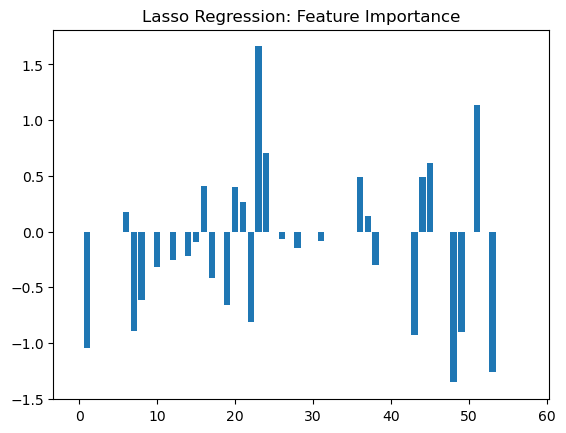

In [240]:
# plot feature importance
importance = lasso_.estimator_.coef_[0]
plt.title("Ridge Regression: Feature Importance")
plt.bar([x for x in range(len(importance))], importance)
plt.title("Lasso Regression: Feature Importance")
plt.show()

In [58]:
# # define the model evaluation by k-fold CV
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# # evaluate the model and collect the scores
# n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

# print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

[False False False  True False False  True  True False  True  True  True
  True  True  True  True  True  True False  True  True  True  True  True
  True  True  True False  True False False  True False False False  True
  True  True  True  True  True False  True  True  True  True  True  True
  True  True  True  True False  True  True False False  True]
Index(['contaminations.1', 'contaminations.4', 'flowvelocity',
       'emergency_measures.1', 'emergency_measures.2', 'emergency_measures.3',
       'emergency_measures.4', 'emergency_measures.6', 'emergency_measures.7',
       'emergency_measures.8', 'emergency_measures.9', 'overall_problem_house',
       'protect_valuables_impl', 'water_barriers_impl',
       'pumping_equipment_impl', 'elevation_building_impl',
       'resistant_material_building_impl', 'electricity_higher_impl',
       'flood_protections_impl', 'flood_experience',
       'elevation_rel2surrounding_cat', 'hh_monthly_income_cat',
       'shp_avgmonthly_sale_cat', 'shp_fi

## Write selected features to disk


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 42 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   contaminations.1                     397 non-null    int64  
 1   contaminations.4                     397 non-null    int64  
 2   flowvelocity                         397 non-null    int64  
 3   emergency_measures.1                 397 non-null    int64  
 4   emergency_measures.2                 397 non-null    int64  
 5   emergency_measures.3                 397 non-null    int64  
 6   emergency_measures.4                 397 non-null    int64  
 7   emergency_measures.6                 397 non-null    int64  
 8   emergency_measures.7                 397 non-null    int64  
 9   emergency_measures.8                 397 non-null    int64  
 10  emergency_measures.9                 397 non-null    int64  
 11  overall_problem_house           

In [150]:
removed_feats = X_train.columns[(lasso_.estimator_.coef_ == 0).ravel().tolist()]
removed_feats

X_train_selected = lasso_.transform(X_train)
X_test_selected = lasso_.transform(X_test)
X_train_selected.shape, X_test_selected.shape

IndexError: boolean index did not match indexed array along dimension 0; dimension is 58 but corresponding boolean dimension is 3480

In [151]:
#X.columns#[(lasso_.estimator_.coef_ == 0).ravel().tolist()]
X_train.columns[(lasso_.get_support())]
print("features with coefficients shrank to zero: {}".format(
np.sum(lasso_.estimator_.coef_ == 0)))

features with coefficients shrank to zero: 3163


In [82]:
removed_feats = X_train.columns[(lasso_.estimator_.coef_ == 0).ravel().tolist()]
removed_feats

X_train_selected = lasso_.transform(X_train)
X_test_selected = lasso_.transform(X_test)
X_train_selected.shape, X_test_selected.shape

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed